In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST

Obtain the MNIST training set, and binarize the first 500 images by mapping any value below .5 to -1 and any value above to 1. For each image, create a noisy version by randomly flipping 2% of the bits

In [12]:
# take data
# NOTE: rename file name by replacing . into -
# For example: t10k-images.idx3-ubyte => t10k-images-idx3-ubyte
# read data from /data
mndata = MNIST('data')
image_total, label_total = mndata.load_training()

In [13]:
train_image = np.array(image_total[:500])                   # we only take first 500 training sets for this homework
train_laebl = np.array(label_total[:500])

binary_train_image = np.where(train_image/255 <= 0.5, -1, 1)      # take number above .5 as 1, and others as -1

noise_train_image = binary_train_image.copy()                     # create a hard copy for noise data

num_sample, num_pixel = binary_train_image.shape

noise_pixel = int(num_pixel * 0.02)                               # compute the number of noise pixels

for i in range(num_sample):                                       # flip some bits of each train_image to create noisy image
    random_pixel = np.random.randint(0, num_pixel, noise_pixel)   # pick pixels
    noise_train_image[i][ random_pixel ] *= -1                    # flip bits

Now denoise each image using a Boltzmann machine model and mean field inference. Use theta_{ij}=0.2 for the H_i, H_j terms and theta_{ij}=0.2 for the H_i, X_j terms. To hand in: Report the fraction of all pixels that are correct in the 500 images.

In [28]:
def pred_and_noisy(image, noise_image, anchor, theta):
    pred_res, noisy_res, theta_hh, theta_hx = 0, 0, theta, theta

    if anchor % 28 != 0:                                          # consider the left side of the neighbor
        noisy_res += theta_hx * noise_image[ anchor - 1 ]
        pred_res += theta_hh * (2 * image[anchor - 1] - 1)

    if (anchor + 1) % 28 != 0:                                    # consider the right side of the neighbor
        noisy_res += theta_hx * noise_image[anchor + 1]
        pred_res += theta_hh * (2 * image[anchor + 1] - 1)

    if anchor >= 28:                                              # consider the top
        noisy_res += theta_hx * noise_image[ anchor - 28 ]
        pred_res += theta_hh * (2 * image[ anchor - 28 ] - 1)

    if anchor < 28 * 27:                                          # consider the bottom
        noisy_res += theta_hx * noise_image[ anchor + 28 ]
        pred_res += theta_hh * (2 * image[ anchor + 28 ] - 1)

    return (pred_res, noisy_res)

def generate_image(image, noise_image, theta):
    image_length = len(image)
    new_image = np.ones( image_length )
    
    for i in range(image_length):                                 # iterate whole image
        prev, noise = pred_and_noisy(image, noise_image, i, theta)# take neighbor from image and noise_image
        new_image[i] = np.exp(prev + noise) / (np.exp(prev + noise) + np.exp(-1.0 * prev + -1.0 * noise))
        
    return new_image

def plot_img(denoised_img, normal_img, noise_img):
    fig = plt.figure(figsize=(3,3))
    
    fig.add_subplot(1, 3, 1)                                      # plot normal
    plt.imshow(normal_img.reshape((28,28)), cmap='gray')
    fig.add_subplot(1, 3, 2)                                      # plot noise
    plt.imshow(noise_img.reshape((28,28)), cmap='gray')
    fig.add_subplot(1, 3, 3)                                      # plot reconstruction
    plt.imshow(denoised_img.reshape((28,28)), cmap='gray')    
    
    plt.show()                                                    # show plots

Prepare a figure showing the original image, the noisy image, and the reconstruction for

your most accurate reconstruction

your least accurate reconstruction

acc_sum: 0.9798852040816326, most accuracy: 0.9961734693877551, least accuracy: 0.9298469387755102


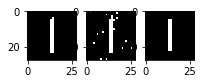

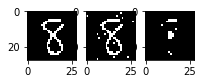

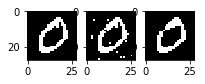

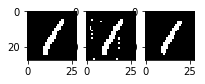

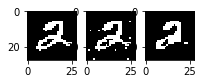

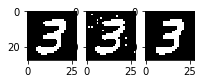

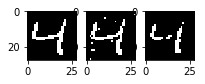

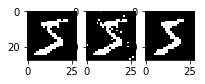

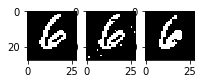

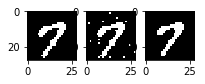

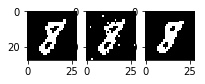

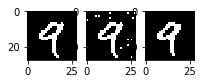

In [32]:
most_acc, least_acc, acc_sum = -np.inf, np.inf, 0
most_acc_img, least_acc_img = np.empty((num_pixel)), np.empty((num_pixel))
most_acc_index, least_acc_index = 0, 0
digit_list = np.array([None for _ in range(10)])

theta_list = [-1, 0, 0.2, 1, 2]
TP_rate, FP_rate = [], []

for theta_index in range(len(theta_list)):
    TP, FP, TN, FN = 0, 0, 0, 0                                     # true positive, false positive, true negative, false negative
    for image_index in range(num_sample):               # run all images
        
        img = np.ones((num_pixel)) 
        
        for _ in range(50):                                         # try 50 times
            new_img = generate_image(img, noise_train_image[image_index], theta_list[theta_index])
            img = new_img

        new_img = np.where(img > 0.5, 1, -1)                    # compute the construction's accuracy
        
        for pixel_index in range(num_pixel):
            if (new_img[pixel_index] == 1):
                if (binary_train_image[image_index][pixel_index] == 1):
                    TP += 1
                else:
                    FP += 1
            else:
                if (binary_train_image[image_index][pixel_index] == -1):
                    TN += 1
                else:
                    FN += 1
                
        if (theta_list[theta_index] == 0.2):                        # when theta is 0.2, compute accuracy sum
            acc = sum(binary_train_image[image_index] == new_img)   # compute accuracy
            acc_sum += acc
            
            if (digit_list[train_laebl[image_index]] == None):        # find first digit figure
                digit_list[train_laebl[image_index]] = (new_img, image_index)
            
            if (acc > most_acc):                                    # update the most accurate
                most_acc = acc
                most_acc_img = new_img
                most_acc_index = image_index
                
            if (acc < least_acc):                                   # update the least accurate
                least_acc = acc
                least_acc_img = new_img
                least_acc_index = image_index
    
    TP_rate.append(TP/(TP+FN))
    FP_rate.append(FP/(FP+TN))
    
    if (theta_list[theta_index] == 0.2):                            # need only when theta = 0.2
        acc_sum /= num_sample * num_pixel
        print('acc_sum: {}, most accuracy: {}, least accuracy: {}'.format(acc_sum, most_acc / num_pixel, least_acc /num_pixel))
        plot_img(most_acc_img, binary_train_image[most_acc_index], noise_train_image[most_acc_index])
        plot_img(least_acc_img, binary_train_image[least_acc_index], noise_train_image[least_acc_index])

for i in range(10):
    denoise_img, img_index = digit_list[i]
    plot_img(denoise_img, binary_train_image[img_index], noise_train_image[img_index] )

Assume that theta_{ij} for the H_i, H_j terms takes a constant value c. We will investigate the effect of different values of c on the performance of the denoising algorithm. Think of your algorithm as a device that accepts an image, and for each pixel, predicts 1 or -1. You can evaluate this in the same way we evaluate a binary classifier, because you know the right value of each pixel. A receiver operating curve is a curve plotting the true positive rate against the false positive rate for a predictor, for different values of some useful parameter. We will use c as our parameter. To hand in: Using c=(-1, 0, 0.2, 1, 2) plot a receiver operating curve for your denoising algorithm.

[0.653125, 0.0, 0.8920072115384615, 0.8780248397435897, 0.8944110576923077]
[0.9268650608044902, 0.0, 0.007290692235734331, 0.00900958840037418, 0.009877806361085126]


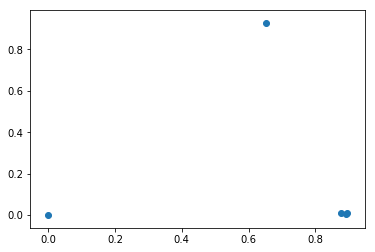

In [33]:
print(TP_rate)
print(FP_rate)

plt.scatter(TP_rate, FP_rate)
plt.show()